In [1]:
import torch
from VRP_Net_L import VRPNet_L
from matplotlib import pyplot as plt
import utils
import os
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import time
import LSE_net
from torch import optim
import importlib
from inference import inference


In [2]:
seed=41;
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
np.random.seed(seed)
print("Running on: " , device)

Running on:  cuda


### Initialize an FLPO scenario

num_drones = 100	num_facilities = 20	dim = 2
Data Loaded.


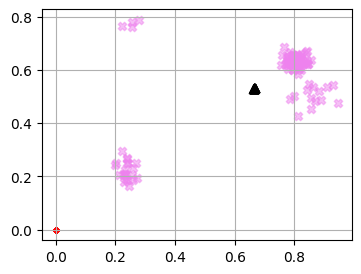

In [3]:
# UAV FLPO MetaData
num_drones = 100
n_drone_clusters = 5
drone_cluster_split = np.random.uniform(0.0, 1.0, n_drone_clusters)
drone_cluster_split = drone_cluster_split / np.sum(drone_cluster_split)
num_facilities = 20
dim_ = 2
print(f'num_drones = {num_drones}\tnum_facilities = {num_facilities}\tdim = {dim_}')

# Assign start location to each drone
drone_cnt = 0
for i in range(n_drone_clusters):
    if i == n_drone_clusters-1:
        n_drones = int(num_drones - drone_cnt)
    else:
        n_drones = int(drone_cluster_split[i] * (num_drones+1))
        drone_cnt += n_drones

    drone_cluster_mean = torch.rand(1, dim_).repeat(n_drones,1).unsqueeze(1).to(device)
    drone_cluster_std = ((0.01 - 0.05) * torch.rand(1,dim_) + 0.05).repeat(n_drones,1).unsqueeze(1).to(device)
    drone_cluster_START_locs = torch.normal(mean=drone_cluster_mean, std=drone_cluster_std).to(device)
    if i == 0:
        START_locs = drone_cluster_START_locs
    else:
        START_locs = torch.cat((START_locs, drone_cluster_START_locs), axis=0)

assert not START_locs.requires_grad, "set requires_grad for START_locs to 0"
# Assign destination location to each drone
END_locs = torch.zeros((num_drones, 1, dim_), requires_grad=False, device=device) #torch.rand(num_drones, 1, dim_, requires_grad=False, device=device)

# Create the data tensor
F_means = torch.mean(START_locs, dim=0).repeat(num_facilities, 1)
F_noise = torch.normal(mean=torch.zeros(num_facilities,1,device=device), std=0.001*torch.ones(num_facilities,1,device=device))
F_base = (F_means + F_noise).unsqueeze(0).requires_grad_()
# print(F_base.shape)
F_locs = F_base.expand(num_drones, -1, -1)  # view, shares grad with F_base
data = torch.cat((START_locs, F_locs, END_locs), dim=1)  # shape: (Nd, Nf+2, D)
print("Data Loaded.")

# plot the data
def plot_UAV_FLPO(drone_START, drone_END, Facilities, figuresize=(6,5)):
    start_locs = drone_START.squeeze(1).cpu().numpy()
    end_locs = drone_END.squeeze(1).cpu().numpy()
    f_locs = Facilities.squeeze(0).detach().cpu().numpy()

    plt.figure(figsize=figuresize)
    plt.scatter(start_locs[:,0], start_locs[:,1], color='violet', marker='X', alpha=0.5)
    plt.scatter(end_locs[:,0], end_locs[:,1], color='red', marker='.')
    plt.scatter(f_locs[:,0], f_locs[:,1], color='black', marker='^')
    plt.grid()
    plt.show()

plot_UAV_FLPO(START_locs, END_locs, F_base, (4,3))


### Load the VRP NET Module

In [4]:
torch.cuda.empty_cache()
model_classes = {"VRPNet_L": VRPNet_L}
weights_address = "Saved models/VRPNet_L_lr1e-04_bs32_ep60000_samples1920000_cities50_inputdim2_workers0_hidden64_enc1_dec1_heads8_dropout0.30_train_PO_2025_05_17_22_43_32last_model.pth"
vrp_net = utils.load_model(weights_address, model_classes, weights_only=True, device=device)
for param in vrp_net.parameters():
    param.requires_grad = False
print("VRP NET loaded on: ", vrp_net.device)
print(summary(vrp_net))

Model created.
VRP NET loaded on:  cuda
Layer (type:depth-idx)                                                 Param #
VRPNet_L                                                               --
├─LinearAttnEncoder: 1-1                                               2,048
│    └─ModuleList: 2-1                                                 --
│    │    └─MultiheadAttention: 3-1                                    (66,048)
│    │    └─MultiheadAttention: 3-2                                    (66,048)
│    │    └─MultiheadAttention: 3-3                                    (66,048)
│    │    └─MultiheadAttention: 3-4                                    (66,048)
│    │    └─MultiheadAttention: 3-5                                    (66,048)
│    │    └─MultiheadAttention: 3-6                                    (66,048)
│    └─ModuleList: 2-2                                                 --
│    │    └─MultiheadAttention: 3-7                                    (66,048)
│    │    └─MultiheadA

### Load the LSE net module

In [5]:
importlib.reload(LSE_net)
lse_data = torch.load('logSumExp_models/lse_2025_5_1__17_6_31.pth', weights_only=False)
n_inputs = lse_data['n_inputs']
n_outputs = lse_data['n_outputs']
layers = lse_data['layers']
weights = lse_data['model_state_dict']
io_scale = lse_data['io_scale']
lse_net = LSE_net.dnn(n_inputs, n_outputs, layers)
lse_net.to(device)
lse_net.load_state_dict(weights)
lse_net.eval()
for p in lse_net.parameters():
    p.requires_grad = False
print(f'n_inputs: {n_inputs}\nn_outputs: {n_outputs}\nlayers: {layers}\nio_scale: {io_scale}\nLSE_net:\n{summary(lse_net)}')

n_inputs: 3
n_outputs: 1
layers: [20, 20, 10]
io_scale: 1
LSE_net:
Layer (type:depth-idx)                   Param #
dnn                                      --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       (80)
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       (420)
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       (210)
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       (11)
Total params: 721
Trainable params: 0
Non-trainable params: 721


### Some functions for free energy approximation

In [6]:
def logSumExp(D_tensor, beta):
    # with torch.no_grad():
    # print(D_tensor)
    D_min = torch.min(D_tensor, axis=1, keepdims=True)
    F = -1/beta * torch.log(torch.sum(torch.exp(-beta*(D_tensor - D_min.values)), axis=1, keepdims=True)) + 1/beta * torch.log(torch.tensor([D_tensor.shape[1]])) + D_min.values
    return F

def area_approx_F(D_min, D_max_range, beta, printCalculations=False):
    min_beta_D_arr = beta * D_min
    x_max = beta * D_max_range - min_beta_D_arr
    F_est = -1/beta * torch.log(1/x_max * (1 - torch.exp(-x_max))) + D_min
    
    if printCalculations:
        print(f'min_beta_D_arr:{min_beta_D_arr}')
        print(f'x_max:{x_max}')
        print(f'inside_log:{1/x_max * (1 - torch.exp(-x_max))}')
        print(f'log:{torch.log(1/x_max * (1 - torch.exp(-x_max)))}')
        print(f'-1/beta_log:\n{-1/beta * torch.log(1/x_max * (1 - torch.exp(-x_max)))}')
        
    return F_est

### Functions to modularize the entire implementation including forward passes of VRP and LSE nets, optimization at fixed beta, annealing iterations

In [7]:
# Shortest path and its gradient wrt facility locations
def VRPNet_pass(vrp_net, F_base, S, E, method = 'Greedy', returnGrad=False):
    F_locs = F_base.expand(num_drones, -1, -1)  # view, shares grad with F_base
    data = torch.cat((S, F_locs, E), dim=1)  # shape: (Nd, Nf+2, D)
    s = time.time()
    with torch.no_grad():
        _ , actions = inference(data , vrp_net , method) # Grad wrt actions not needed
    e = time.time()
    
    D_min_drones = utils.route_cost(data, actions).view(-1,1)
    
    if returnGrad:
        gradient = torch.autograd.grad(outputs=D_min_drones, inputs=F_base,
                                grad_outputs=torch.ones_like(D_min_drones),
                                )
        
        dDmin_dFlocs = gradient[0]
        
        
    else:
        dDmin_dFlocs = None

    return D_min_drones, dDmin_dFlocs, e-s

# Free energy as a function of shortest path, and its gradients
def LSENet_pass(lse_net, D_min_drones, D_max_range, beta, beta_min, returnGrad=False):
    device = D_min_drones.device
    
    Fmin_est = area_approx_F(D_min_drones, D_max_range=D_max_range, beta=beta_min, printCalculations=False)
    Fmin_est.detach()
    In_lse = torch.cat((
        Fmin_est.to(device),
        D_min_drones,
        (torch.ones(D_min_drones.shape,device=device)*torch.log(torch.tensor([beta],device=device))/torch.log(torch.tensor([10.0],device=device)))
    ), axis=1)
    FreeEnergy = lse_net(In_lse)
    
    if returnGrad:
        gradient = torch.autograd.grad(outputs=FreeEnergy, inputs=In_lse,
                                grad_outputs=torch.ones_like(FreeEnergy),
                                )
        # dFreeE_dDmin = gradient[0].view(num_drones,1,1)
        
        
        dFreeE_dDmin = gradient[0][:,1].view(-1,1).view(num_drones,1,1)
    else:
        dFreeE_dDmin = None
    return FreeEnergy, dFreeE_dDmin

# gradient descent step
def gradient_descent_step(Y, dY, eta):
    Y = Y - eta * dY
    return Y

# optimize using gradient descent at given beta
def GD_at_beta0(F_base, S, E, vrp_net, lse_net, iters, optim_stepsize, beta_min, beta, D_max_range, allowPrint=False):

    num_drones = S.shape[0]
    assert(S.requires_grad == False)

    for i in range(iters):
        
        
        # free energy and gradients using VRP_net and LSE_net
        D_min_drones, dDmin_dFlocs, _ = VRPNet_pass(vrp_net, F_base,S,E, returnGrad=True)
        freeEnergy_drones, dFreeE_dDmin = LSENet_pass(
            lse_net, D_min_drones, D_max_range=D_max_range, 
            beta=beta, beta_min=beta_min, returnGrad=True)

        torch.cuda.empty_cache()
        print(dDmin_dFlocs.shape)
        print(dFreeE_dDmin.shape)
        # total gradient using chain rule and backpropagation
        total_gradient = dDmin_dFlocs * dFreeE_dDmin.mean()
        G = torch.mean(total_gradient, axis=0)
 
        # optimizer step
        F_base = gradient_descent_step(F_base, G, optim_stepsize)

        # print data
        if allowPrint:
            print(f'iter: {i}\tFreeE: {torch.mean(freeEnergy_drones):.4e}\tdDmin: {torch.max(torch.abs(dDmin_dFlocs)):.4e}\tdFreeE: {torch.max(torch.abs(dFreeE_dDmin)):.4e}\t G:{torch.max(torch.abs(G)):.4e}')

    return F_base, freeEnergy_drones, G

# optimize using gradient descent at given beta
def GD_at_beta1(F_base0, num_drones, vrp_net, lse_net, iters, optim_stepsize, beta_min, beta, D_max_range, allowPrint=False):

    F_base = F_base0
    assert(F_base.requires_grad == True)

    for i in range(iters):
        
        F_locs = F_base.expand(num_drones, -1, -1)  # view, shares grad with F_base
        
        # free energy and gradients using VRP_net and LSE_net
        D_min_drones, _, _ = VRPNet_pass(vrp_net, F_locs, returnGrad=False)
        freeEnergy_drones, _ = LSENet_pass(
            lse_net, D_min_drones, D_max_range=D_max_range, 
            beta=beta, beta_min=beta_min, returnGrad=False)
        freeEnergy = torch.mean(freeEnergy_drones)

        torch.cuda.empty_cache()

        # total gradient using chain rule and backpropagation
        total_gradient = torch.autograd.grad(outputs=freeEnergy, inputs=F_base,
                                grad_outputs=torch.ones_like(freeEnergy),
                                create_graph=True)
        G = total_gradient[0]

        # optimizer step
        F_base = gradient_descent_step(F_base, G, eta)

        # print data
        if allowPrint:
            print(f'iter: {i}\tFreeE: {freeEnergy:.4e}\tG:{torch.max(torch.abs(G)):.4e}')

    return F_base, freeEnergy_drones, G


def Adam_at_beta(F_base, S, E, vrp_net, lse_net, iters, optim_stepsize, beta_min, beta, D_max_range, allowPrint=False):

    num_drones = S.shape[0]
    
    assert(F_base.requires_grad == True)
    optimizer = optim.Adam([F_base], lr=optim_stepsize)

    for i in range(iters):
        F_locs = F_base.expand(num_drones, -1, -1)  # view, shares grad with F_base
        data = torch.cat((S, F_locs, E), dim=1)  # shape: (Nd, Nf+2, D)
        # free energy and gradients using VRP_net and LSE_net
        D_min_drones, _, _ = VRPNet_pass(vrp_net, data)
        freeEnergy_drones, _ = LSENet_pass(
            lse_net, D_min_drones, D_max_range=D_max_range, beta=beta, beta_min=beta_min)
        FreeEnergy = torch.mean(freeEnergy_drones)

        torch.cuda.empty_cache()

        # compute gradient of free energy wrt F_base using backpropagation
        optimizer.zero_grad()
        FreeEnergy.backward()
        G = F_base.grad
        with torch.no_grad():
            print(f"Norm gradient: {torch.norm(G).item():.3f}")
        # optimizer step
        optimizer.step()

        # print data
        if allowPrint:
            print(f'iter: {i}\tFreeE: {FreeEnergy:.4e}')
    
    return F_base, FreeEnergy, G


# perform annealing
def anneal(F_base0, num_drones, vrp_net, lse_net, iters, step, beta_min, beta_max, beta_grow, D_max_range, optimizer_name, allowPrint):

    beta = beta_min
    F_base = F_base0
    b_arr = []
    F_arr = []

    while beta <= beta_max:
        # optimize using gradient descent iterations

        if optimizer_name == 'gradient_descent0':
            F_base, FreeEnergy, G = GD_at_beta0(
                F_base, num_drones, vrp_net, lse_net, optim_iters, 
                optim_step, beta_min, beta, D_max_range=D_max_range, allowPrint=False)
        
        elif optimizer_name == 'gradient_descent1':
            F_base, FreeEnergy, G = GD_at_beta1(
                F_base, num_drones, vrp_net, lse_net, optim_iters, 
                optim_step, beta_min, beta, D_max_range=D_max_range, allowPrint=False)

        elif optimizer_name == 'adam':
            F_base, FreeEnergy, G = Adam_at_beta(
                F_base, num_drones, vrp_net, lse_net, optim_iters, 
                optim_step, beta_min, beta, D_max_range=D_max_range, allowPrint=False)

        # store data
        b_arr.append(beta)
        F_arr.append(torch.mean(FreeEnergy).detach().item())
        # print data
        if allowPrint:
            print(f'beta: {beta:.4e}\tFreeE: {torch.mean(FreeEnergy):.4f}\tGrad: {torch.abs(torch.max(G)):.4e}')
        # update beta
        beta = beta * beta_grow

    return F_base, b_arr, F_arr


    

### Optimization loop for a single beta

#### using gradient descent 0

In [8]:
optim_iters = 500
optim_step = 0.01
b_min = 1e-3
beta = 1e3
F_base, FreeEnergy, G = GD_at_beta0(
    F_base, START_locs, END_locs, vrp_net, lse_net, optim_iters, 
    optim_step, b_min, beta, D_max_range=2.0, allowPrint=True)


torch.Size([1, 20, 2])
torch.Size([100, 1, 1])
iter: 0	FreeE: 6.3644e-01	dDmin: 8.6758e+01	dFreeE: 1.0309e+00	 G:8.9163e+01
torch.Size([1, 20, 2])
torch.Size([100, 1, 1])
iter: 1	FreeE: 6.1152e-01	dDmin: 9.8179e+01	dFreeE: 1.0309e+00	 G:1.0087e+02
torch.Size([1, 20, 2])
torch.Size([100, 1, 1])
iter: 2	FreeE: 6.1069e-01	dDmin: 9.8271e+01	dFreeE: 1.0309e+00	 G:1.0103e+02
torch.Size([1, 20, 2])
torch.Size([100, 1, 1])
iter: 3	FreeE: 6.0202e-01	dDmin: 9.8353e+01	dFreeE: 1.0309e+00	 G:1.0111e+02
torch.Size([1, 20, 2])
torch.Size([100, 1, 1])
iter: 4	FreeE: 6.0289e-01	dDmin: 9.8424e+01	dFreeE: 1.0309e+00	 G:1.0118e+02
torch.Size([1, 20, 2])
torch.Size([100, 1, 1])
iter: 5	FreeE: 6.0581e-01	dDmin: 8.8059e+01	dFreeE: 1.0309e+00	 G:9.0527e+01
torch.Size([1, 20, 2])
torch.Size([100, 1, 1])
iter: 6	FreeE: 6.0985e-01	dDmin: 9.8819e+01	dFreeE: 1.0309e+00	 G:1.0147e+02
torch.Size([1, 20, 2])
torch.Size([100, 1, 1])
iter: 7	FreeE: 5.9773e-01	dDmin: 9.8194e+01	dFreeE: 1.0309e+00	 G:1.0095e+02
torch.Si

KeyboardInterrupt: 

#### using gradient descent 1 (comment the other two optimization implementations)

In [28]:
# optim_iters = 500
# optim_step = 0.001
# b_min = 1e-3
# beta = 1e-3

# F_base, FreeEnergy, G = Adam_at_beta(
#     F_base, num_drones, vrp_net, lse_net, optim_iters, 
#     optim_step, b_min, beta, D_max_range=2.0, allowPrint=True)


#### using Adam optimizer from torch.optim (comment the other two optimization implementations)

In [27]:
# optim_iters = 1000
# optim_step = 0.01
# b_min = 1e-3
# beta = 1e-3

# F_base, FreeEnergy, G = GD_at_beta1(
#     F_base, num_drones, vrp_net, lse_net, optim_iters, 
#     optim_step, b_min, beta, D_max_range=2.0, allowPrint=True)


In [25]:
F_base

tensor([[[0.7889, 0.3893],
         [0.7897, 0.3969],
         [0.7885, 0.3976],
         [0.7898, 0.3966],
         [0.7432, 0.3779]]], grad_fn=<SubBackward0>)

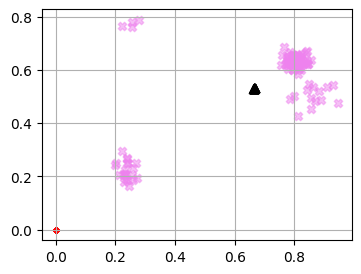

In [9]:
plot_UAV_FLPO(START_locs, END_locs, F_base, (4,3))

### Annealing loop implementation

In [43]:
beta_min = 1e-3
beta_max = 1e5
beta_grow = 3
beta = 1e-3
optim_iters = 200
optim_step = 0.1 # 0.1 for gd0, use < 0.01 for the other two optimizers

F_base, b_arr, F_arr = anneal(
    F_base, num_drones, vrp_net, lse_net, optim_iters, optim_step, 
    beta_min, beta_max, beta_grow, D_max_range=2.0, 
    optimizer_name='gradient_descent0', allowPrint=True)


beta: 1.0000e-03	FreeE: 1.3718	Grad: 1.0314e-03
beta: 3.0000e-03	FreeE: 1.3534	Grad: 9.4309e-04
beta: 9.0000e-03	FreeE: 1.3310	Grad: 9.4154e-04
beta: 2.7000e-02	FreeE: 1.1542	Grad: 2.6768e-03
beta: 8.1000e-02	FreeE: 1.0838	Grad: 5.1806e-03
beta: 2.4300e-01	FreeE: 1.0567	Grad: 6.4388e-03
beta: 7.2900e-01	FreeE: 0.9776	Grad: 4.3463e-06
beta: 2.1870e+00	FreeE: 0.8144	Grad: 2.9206e-07
beta: 6.5610e+00	FreeE: 0.5622	Grad: 2.9206e-07
beta: 1.9683e+01	FreeE: 0.3717	Grad: 2.7120e-07
beta: 5.9049e+01	FreeE: 0.2432	Grad: 4.4195e-03
beta: 1.7715e+02	FreeE: 0.2160	Grad: 2.0672e-02
beta: 5.3144e+02	FreeE: 0.1882	Grad: 4.6555e-05
beta: 1.5943e+03	FreeE: 0.1873	Grad: 3.0335e-08
beta: 4.7830e+03	FreeE: 0.1864	Grad: 3.0335e-08
beta: 1.4349e+04	FreeE: 0.1855	Grad: 3.0335e-08
beta: 4.3047e+04	FreeE: 0.1846	Grad: 3.0335e-08


In [44]:
F_base

tensor([[[0.5649, 0.2896],
         [0.6738, 0.3355],
         [0.2933, 0.1494],
         [0.4400, 0.2241],
         [0.1467, 0.0747]]], grad_fn=<SubBackward0>)

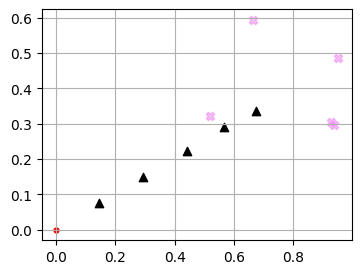

In [45]:
plot_UAV_FLPO(START_locs, END_locs, F_base, (4,3))

### Plot free energy during annealing implementation

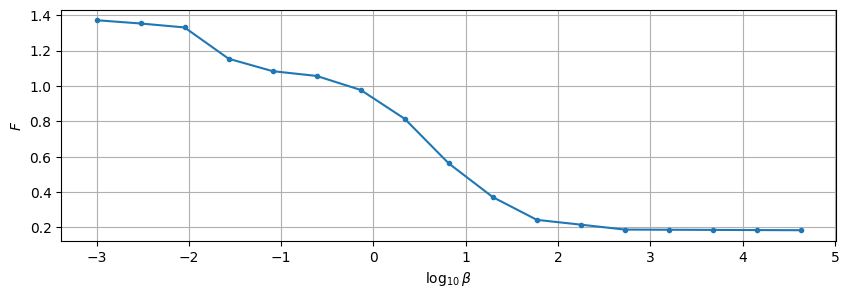

In [51]:
# plot free energy evolution
plt.figure(figsize=(10,3))
plt.plot(np.log(b_arr)/np.log(10), F_arr, marker='.')
plt.ylabel(rf'$F$')
plt.xlabel(rf'$\log_{{10}}\beta$')
plt.grid()
plt.show()